In [1]:
%matplotlib widget
import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 128
L = 1
u_mag = 5
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-2.2,-1.2]
config['domain']['maxExtent'] =  [2.2,1.2]
config['domain']['periodic'] = False
# config['kernel'] = {'name':'Wendland4'}

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda', 'checkNaN': True}
# config['compute'] = {'device': 'cpu'}


config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['diffusion']['alpha'] = 0.01
config['diffusion']['pi-switch']=False
config['gravity']['active'] = True
config['EOS']['type'] = 'stiffTait'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 1000.0, $\nu_{sph} = 0.009999999776482582$, $\alpha = 0.01$


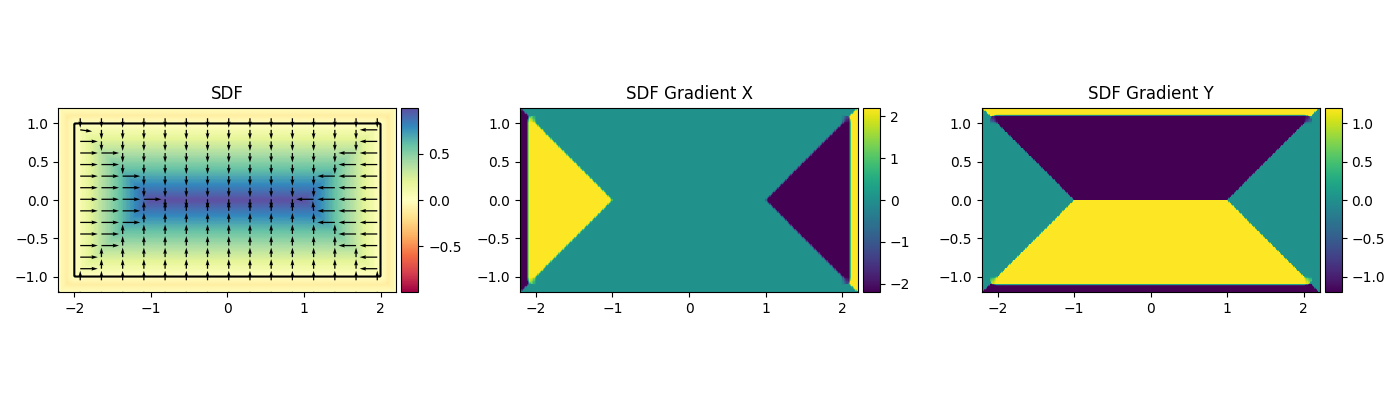

In [5]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 3,1 + config['particle']['support'] * 3]).to(points.device))


translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)

outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
sdf = operatorDict['invert'](sdf)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sdf
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [6]:
from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

In [7]:


ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 2,1 + config['particle']['support'] * 2]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](sdf)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1/2]).to(points.device))
fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [8]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs
from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient

particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'])
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')


config['timestep']['dt'] = 1e-3
s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1

perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)


p = perennialState['boundary']['positions']
# inner()
sdf = inner
h = config['particle']['support']

stencil = centralDifferenceStencil(1, 2)
stencil = stencil.to(p.device)
sdfValues = sdf(p.cpu()).to(p.device)

sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
perennialState['boundary']['normals'] = -sdfGradient / (torch.linalg.norm(sdfGradient, dim = 1, keepdim = True) + 1e-6)
perennialState['boundary']['distances'] = sdfValues

In [9]:
from diffSPH.v2.plotting import visualizeParticleQuantity

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-03 s, particles: 8169 (2809 fluid + 5360 boundary)')

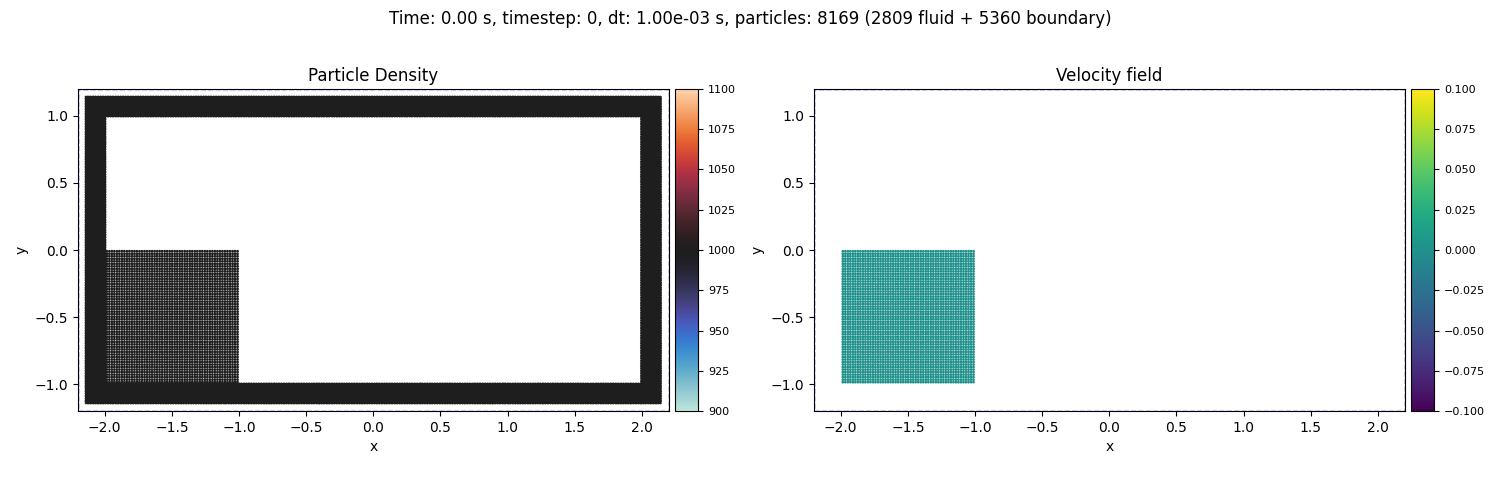

In [10]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'both', plotBoth = True, midPoint = 1000)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False, which = 'fluid', midPoint = 1000)


# axis[0,0].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)
# axis[0,1].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [11]:
config['shifting']['scheme'] = 'deltaPlus'
config['integration']['scheme'] = 'symplecticEuler'
config['boundary']
config['EOS']['type'] = 'isoThermal'
config['neighborhood']['verletScale'] = 1.5
# perennialState['dt']
# config['kernel']['name'] = 'Wendland4'

In [12]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN

priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 32 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'densities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)

    for emitter in config['regions']:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/4096 [00:00<?, ?it/s]

In [12]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x5bae5da9e200] Dupped color: FFFDFFFE


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_06_12-14_18_27/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_06_12-14_18_27.gif'], returncode=0)